In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import random as rn
import csv
import os
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
# tensorflowの乱数シード固定(再現性の担保)
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(7)
rn.seed(7)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

tf.set_random_seed(7)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
batch_size = 32
n_epochs = 50

# 画像データ取り込み


In [4]:
DATA_FOLDER = '../data/'
datalist = pd.read_csv(os.path.join(DATA_FOLDER, 'frames_data.csv'), names=["img_path", "l_class", 's_class','timestamp'])
datalist.head()

,img_path,l_class,s_class,timestamp
0,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan,5gokan-denkisogokan,2019/10/23 18:50:43
1,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan,5gokan-denkisogokan,2019/10/23 18:50:43
2,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan,5gokan-denkisogokan,2019/10/23 18:50:43
3,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan,5gokan-denkisogokan,2019/10/23 18:50:43
4,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan,5gokan-denkisogokan,2019/10/23 18:50:43


In [5]:
l_classlist = ['4gokan', '5gokan', '5gokan-denkisogokan', '5gokan-mediacenter'
                    '8gokan', 'denkisogokan', 'lab', 'lab-lounge', 'lounge']
s_classlist = ['4gokan_inside', '4gokan_outside', '5gokan-denkisogokan', '5gokan-mediacenter',
'5gokan_1F', '5gokan_2F', '5gokan_3F', '5gokan_ent_east', '5gokan_lounge',
'5gokan_out_east', '5gokan_parking', '5gokan_smoking', '5gokan_stairs_cnt',
'5gokan_stairs_west', '8gokan_1F', '8gokan_ent_north', '8gokan_ent_south',
'denkisogokan_2F', 'denkisogokan_3F', 'denkisogokan_4F', 'denkisogokan_elevator',
'denkisogokan_lounge', 'denkisogokan_stairs', 'lab-lounge', 'lab_bs_cnt',
'lab_corner', 'lab_desk', 'lab_desk_table', 'lab_ent', 'lab_printer',
'lab_table', 'lab_wb_cnt', 'lab_wb_ent', 'lounge']
num_l_class =len(l_classlist)
num_s_class = len(s_classlist)

In [6]:
print(num_s_class)

34


In [7]:
dfl = datalist.drop(['s_class','timestamp'], axis=1)
dfl.head()

,img_path,l_class
0,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan
1,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan
2,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan
3,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan
4,../data/insta_frames/5gokan-denkisogokan/5goka...,5gokan-denkisogokan


In [8]:
dfl.groupby('l_class').count()

,img_path
l_class,
4gokan,308
5gokan,1328
5gokan-denkisogokan,361
5gokan-mediacenter,127
8gokan,266
denkisogokan,523
lab,1953
lab-lounge,63
lounge,247


In [9]:
dfs = datalist.drop(['l_class', 'timestamp'], axis=1)
dfs.groupby('s_class').count()

,img_path
s_class,
4gokan_inside,60
4gokan_outside,248
5gokan-denkisogokan,361
5gokan-mediacenter,127
5gokan_1F,65
5gokan_2F,96
5gokan_3F,32
5gokan_ent_east,135
5gokan_lounge,361


In [10]:
grad_test_img_path =[
    "../data/insta_frames/4gokan/4gokan_inside/4gokan_inside_0_img_000030.png",
    "../data/insta_frames/4gokan/4gokan_outside/4gokan_outside_0_img_000030.png",
    "../data/insta_frames/5gokan-denkisogokan/5gokan-denkisogokan_0_img_000030.png",
    "../data/insta_frames/5gokan-mediacenter/5gokan-mediacenter_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_1F/5gokan_1F_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_2F/5gokan_2F_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_3F/5gokan_3F_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_ent_east/5gokan_ent_east_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_lounge/5gokan_lounge_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_out_east/5gokan_out_east_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_parking/5gokan_parking_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_smoking/5gokan_smoking_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_stairs_cnt/5gokan_stairs_cnt_0_img_000030.png",
    "../data/insta_frames/5gokan/5gokan_stairs_west/5gokan_stairs_west_0_img_000030.png",
    "../data/insta_frames/8gokan/8gokan_1F/8gokan_1F_0_img_000030.png",
    "../data/insta_frames/8gokan/8gokan_ent_north/8gokan_ent_north_0_img_000030.png",
    "../data/insta_frames/8gokan/8gokan_ent_south/8gokan_ent_south_1_img_000030.png",
    "../data/insta_frames/denkisogokan/denkisogokan_2F/denkisogokan_2F_0_img_000030.png",
    "../data/insta_frames/denkisogokan/denkisogokan_3F/denkisogokan_3F_0_img_000030.png",
    "../data/insta_frames/denkisogokan/denkisogokan_4F/denkisogokan_4F_0_img_000030.png",
    "../data/insta_frames/denkisogokan/denkisogokan_elevator/denkisogokan_elevator_0_img_000030.png",
    "../data/insta_frames/denkisogokan/denkisogokan_lounge/denkisogokan_lounge_0_img_000030.png",
    "../data/insta_frames/denkisogokan/denkisogokan_stairs/denkisogokan_stairs_0_img_000030.png",
    "../data/insta_frames/lab-lounge/lab-lounge_0_img_000030.png",
    "../data/insta_frames/lab/lab_bs_cnt/lab_bs_cnt_0_img_000030.png",
    "../data/insta_frames/lab/lab_corner/lab_corner_0_img_000030.png",
    "../data/insta_frames/lab/lab_desk/lab_desk_0_img_000030.png",
    "../data/insta_frames/lab/lab_desk_table/lab_desk_table_0_img_000030.png",
    "../data/insta_frames/lab/lab_ent/lab_ent_0_img_000030.png",
    "../data/insta_frames/lab/lab_printer/lab_printer_0_img_000030.png",
    "../data/insta_frames/lab/lab_table/lab_table_0_img_000030.png",
    "../data/insta_frames/lab/lab_wb_cnt/lab_wb_cnt_0_img_000030.png",
    "../data/insta_frames/lab/lab_wb_ent/lab_wb_ent_0_img_000030.png",
    "../data/insta_frames/lounge/lounge_0_img_000030.png",
]

# Markdown
from sklearn.preprocessing import LabelEncoder

# Markdown
le = LabelEncoder()
le.fit(dfs.s_class)
dfs["labels"] = le.transform(dfs.s_class)
dfs.groupby('labels')

# Markdown
cor_table = dfs.groupby('labels').s_class.unique()
cor_table = pd.DataFrame(cor_table)
cor_table.head()

# Markdown
cor_table.to_csv('cor_table.csv', index=False)

# Markdown
dfs = dfs.drop(['s_class'], axis=1)

# Markdown
x = []
for i in range(len(dfs.img_path)):
    image = img_to_array(load_img(dfs.img_path[i], target_size=(224,224)))
    x.append(image)

# Markdown
y = dfs.labels
print(y)

# Markdown
#正規化
x = np.array(x, dtype='float32')/255

# Markdown
#np.array形式のデータを保存　x, y
np.save(file='x.npy', arr=x)
np.save(file='y.npy', arr=y)

In [11]:
#x, yをload
x = np.load(file='x.npy')
y = np.load(file='y.npy')

In [12]:
print(x.shape)
print(y.shape)

(5176, 224, 224, 3)
(5176,)


# train test & validation set split

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
x, x_valid, y, y_valid = train_test_split(x,y, random_state=42, test_size=0.2, stratify=y)

# EDA(探索的データ解析)


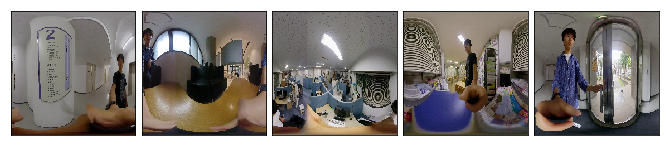

In [15]:
fig = plt.figure(figsize=(9,18))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    ax.imshow(x[i])

# CNN(keras NotPretrained)

In [16]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, add, Add, Dropout, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
inputs = Input(shape=(224,224,3))
x1 = Conv2D(64, kernel_size=(3,3), activation='relu')(inputs)
x2 = Conv2D(64, kernel_size=(3,3), activation='relu')(x1)
x3 = MaxPooling2D(pool_size=(2,2))(x2)
x4 = Conv2D(128, kernel_size=(3,3), activation='relu')(x3)
x5 = Conv2D(128, kernel_size=(3,3), activation='relu')(x4)
x6 = MaxPooling2D(pool_size=(2,2))(x5)
x7 = Flatten()(x6)
prediction = Dense(num_s_class, activation='softmax')(x7)

model = Model(inputs=inputs, outputs=prediction)
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto')
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
model.save('omni_video.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 128)       0         
__________

In [19]:
feature1 = GlobalMaxPooling2D(name='Conv2D_1')(x1)
feature2 = GlobalMaxPooling2D(name='Conv2D_1')(x2)
feature3 = GlobalMaxPooling2D(name='Conv2D_1')(x3)
feature4 = GlobalMaxPooling2D(name='Conv2D_1')(x4)
feature5 = GlobalMaxPooling2D(name='Conv2D_1')(x5)
feature6 = GlobalMaxPooling2D(name='Conv2D_1')(x6)

In [20]:
hidden_model1 = Model(inputs=model.input, outputs=feature1)
hidden_model2 = Model(inputs=model.input, outputs=feature2)
hidden_model3 = Model(inputs=model.input, outputs=feature3)
hidden_model4 = Model(inputs=model.input, outputs=feature4)
hidden_model5 = Model(inputs=model.input, outputs=feature5)
hidden_model6= Model(inputs=model.input, outputs=feature6)

   # 層化抽出法(Stratified sampling)&KFold

In [21]:
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils

Using TensorFlow backend.


In [22]:
y.shape

(4140,)

In [23]:
skf = StratifiedKFold(n_splits=5, random_state=42)
cvscores = []
#Stratified KFoldはlabel encoding化した整数ベクトルでないともちいることができない
x = np.array(x)
y = np.array(y)
for train_index, test_index in skf.split(x, y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #One-hot化　CNNに入出力できるように整形
    y_train = np_utils.to_categorical(y_train, num_s_class)
    y_test = np_utils.to_categorical(y_test, num_s_class)
    model.fit(x_train, y_train, verbose=1, batch_size=batch_size, epochs=n_epochs,
              callbacks=[early_stopping], validation_split=0.2)
    scores = model.evaluate(x_test, y_test)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

Train on 2639 samples, validate on 660 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
2639/2639 [==============================] - 17s 6ms/sample - loss: 1.5469 - acc: 0.6260 - val_loss: 0.5238 - val_acc: 0.8652
Epoch 2/50
2639/2639 [==============================] - 13s 5ms/sample - loss: 0.1543 - acc: 0.9629 - val_loss: 0.3592 - val_acc: 0.9348
Epoch 3/50
2639/2639 [==============================] - 13s 5ms/sample - loss: 0.0385 - acc: 0.9917 - val_loss: 0.3430 - val_acc: 0.9288
Epoch 4/50
2639/2639 [==============================] - 13s 5ms/sample - loss: 0.0367 - acc: 0.9936 - val_loss: 0.3741 - val_acc: 0.9242
Epoch 00004: early stopping
841/841 [==============================] - 2s 2ms/sample - loss: 0.3390 - acc: 0.9370
acc: 93.70%
Train on 2645 samples, validate on 662 samples
Epoch 1/50
2645/2645 [==============================] - 14s 5ms/sample - loss: 0.1327 - acc: 0.9724 - val_loss: 0.2394 - val_acc: 0.9637
Epoch 2/50
2645/2645 [=========================

In [24]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

98.03% (+/- 2.31%)


→ validation_dataを用意しないとval_lossを計算できない

# Confusion Matrix

In [25]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from scipy.sparse.csgraph import connected_components

In [26]:
y_pred = model.predict(x_valid)

In [27]:
y_valid = np_utils.to_categorical(y_valid)

In [28]:
y_pred = np.array(y_pred)
y_true = np.array(y_valid)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_true, axis=1)

In [29]:
print(y_pred.shape)
print(y_true.shape)

(1036,)
(1036,)


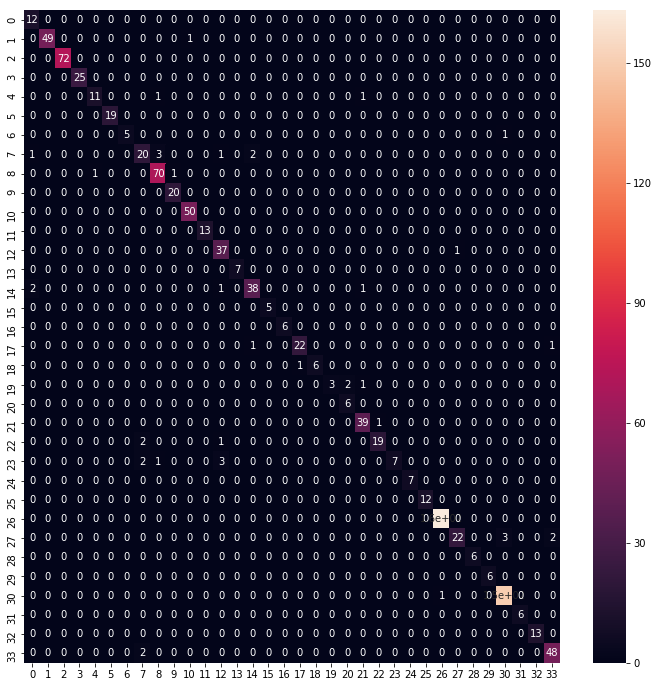

accuracy: 0.9594594594594594


In [30]:
cmx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cmx, annot=True)
plt.show()
print('accuracy: {}'.format(accuracy_score
(y_true, y_pred)))

In [31]:
cor_table = pd.read_csv('cor_table.csv')
print(cor_table)

                      s_class
0           ['4gokan_inside']
1          ['4gokan_outside']
2     ['5gokan-denkisogokan']
3      ['5gokan-mediacenter']
4               ['5gokan_1F']
5               ['5gokan_2F']
6               ['5gokan_3F']
7         ['5gokan_ent_east']
8           ['5gokan_lounge']
9         ['5gokan_out_east']
10         ['5gokan_parking']
11         ['5gokan_smoking']
12      ['5gokan_stairs_cnt']
13     ['5gokan_stairs_west']
14              ['8gokan_1F']
15       ['8gokan_ent_north']
16       ['8gokan_ent_south']
17        ['denkisogokan_2F']
18        ['denkisogokan_3F']
19        ['denkisogokan_4F']
20  ['denkisogokan_elevator']
21    ['denkisogokan_lounge']
22    ['denkisogokan_stairs']
23             ['lab-lounge']
24             ['lab_bs_cnt']
25             ['lab_corner']
26               ['lab_desk']
27         ['lab_desk_table']
28                ['lab_ent']
29            ['lab_printer']
30              ['lab_table']
31             ['lab_wb_cnt']
32        

# 中間層特徴量の可視化

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [33]:
hidden1 = hidden_model1.predict(x_train)
hidden2 = hidden_model2.predict(x_train)
hidden3 = hidden_model3.predict(x_train)
hidden4 = hidden_model4.predict(x_train)
hidden5 = hidden_model5.predict(x_train)
hidden6 = hidden_model6.predict(x_train)

In [34]:
print(hidden1.shape)
print(hidden2.shape)
print(hidden3.shape)
print(hidden4.shape)
print(hidden5.shape)
print(hidden6.shape)

(3325, 64)
(3325, 64)
(3325, 64)
(3325, 128)
(3325, 128)
(3325, 128)


#標準化
scaler = StandardScaler()
scaler.fit(hidden1)
hidden1 = scaler.transform(hidden1)
scaler.fit(hidden2)
hidden1 = scaler.transform(hidden2)
scaler.fit(hidden3)
hidden1 = scaler.transform(hidden3)
scaler.fit(hidden4)
hidden1 = scaler.transform(hidden4)
scaler.fit(hidden5)
hidden1 = scaler.transform(hidden5)
scaler.fit(hidden6)
hidden1 = scaler.transform(hidden6)

In [35]:
pca = PCA()

In [36]:
cm_name = 'jet'
cmap = plt.get_cmap(cm_name, num_s_class)

In [37]:
# one-hotから整数値ベクトルに変換
y_train_vec = []
for i in range(len(y_train)):
    y_train_vec.append(np.argmax(y_train[i]))

# 1層目の特徴ベクトル(Conv2D)

In [38]:
feature1 = pca.fit_transform(hidden1)
#　主成分分析の例(1層目)
df_feature1 = pd.DataFrame(feature1)
print(df_feature1)

            0         1         2         3         4         5         6   \
0     0.404244  0.017223  0.016723  0.022349  0.019912 -0.005548 -0.018452   
1    -0.028201 -0.103433  0.059074 -0.074032  0.039682 -0.013891 -0.019063   
2    -0.085454  0.085863 -0.035849  0.026493  0.020510  0.019162  0.024745   
3     0.045209  0.067746 -0.075069  0.037943  0.025278 -0.054933 -0.022976   
4    -0.015948 -0.038044 -0.001871 -0.023260  0.000570  0.011743  0.004032   
5     0.029120  0.104431 -0.005435 -0.008699 -0.044959  0.009696 -0.017682   
6    -0.248079  0.131396 -0.038985 -0.060183 -0.022975  0.014471  0.036665   
7    -0.375781  0.119403  0.105577 -0.023047 -0.072231  0.034009  0.077046   
8     0.205157 -0.056065 -0.035925  0.002765  0.006948 -0.020166  0.039100   
9     0.092744  0.016145  0.023777  0.071815 -0.231352 -0.142979  0.205475   
10   -0.111633 -0.113392 -0.078674  0.004832 -0.009684  0.030330 -0.025518   
11   -0.130428 -0.036354  0.067726  0.010099 -0.043035 -0.003305

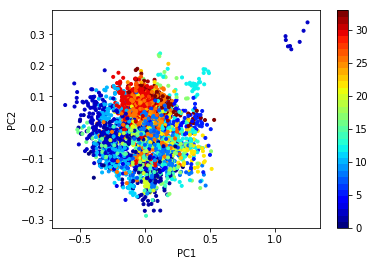

In [39]:
plt.scatter(feature1[:,0],feature1[:,1], marker=".", c=y_train_vec, cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

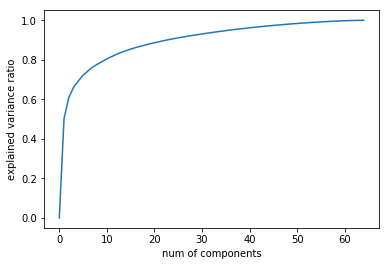

In [40]:
pca.fit(hidden1)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0, ev_ratio.cumsum()])
plt.xlabel("num of components")
plt.ylabel("explained variance ratio")
plt.plot(ev_ratio)
plt.show()

# 2層目の特徴ベクトル (Conv2D)

In [41]:
feature2 = pca.fit_transform(hidden2)

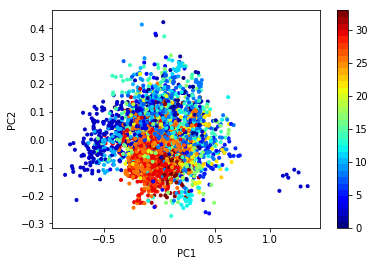

In [42]:
plt.scatter(feature2[:,0],feature2[:,1], marker=".", c=y_train_vec, cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

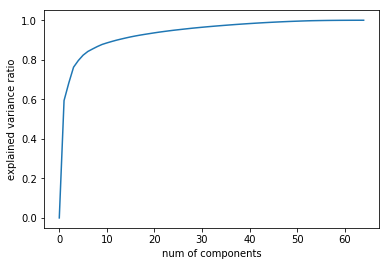

In [43]:
pca.fit(hidden2)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0, ev_ratio.cumsum()])
plt.xlabel("num of components")
plt.ylabel("explained variance ratio")
plt.plot(ev_ratio)
plt.show()

# 3層目の特徴ベクトル (MaxPooling2D)

In [44]:
feature3 = pca.fit_transform(hidden3)

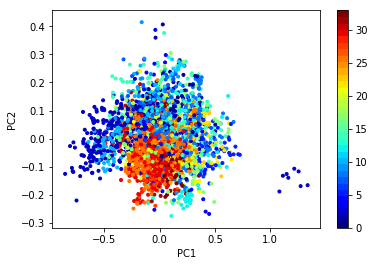

In [45]:
plt.scatter(feature3[:,0],feature3[:,1], marker=".", c=y_train_vec, cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

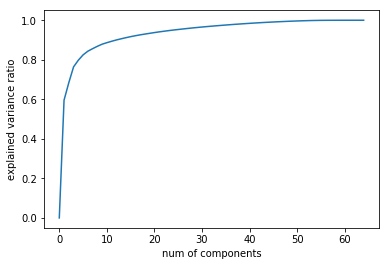

In [46]:
pca.fit(hidden3)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0, ev_ratio.cumsum()])
plt.xlabel("num of components")
plt.ylabel("explained variance ratio")
plt.plot(ev_ratio)
plt.show()

# 4層目の特徴ベクトル (Conv2D)

In [47]:
feature4 = pca.fit_transform(hidden4)

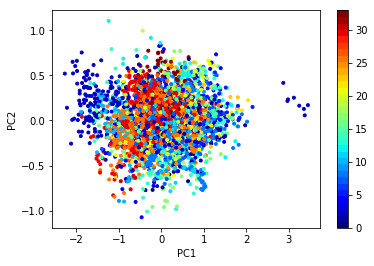

In [48]:
plt.scatter(feature4[:,0],feature4[:,1], marker=".", c=y_train_vec, cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

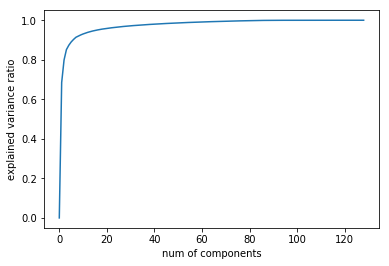

In [49]:
pca.fit(hidden4)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0, ev_ratio.cumsum()])
plt.xlabel("num of components")
plt.ylabel("explained variance ratio")
plt.plot(ev_ratio)
plt.show()

# 5層目の特徴ベクトル (Conv2D)

In [50]:
feature5 = pca.fit_transform(hidden5)

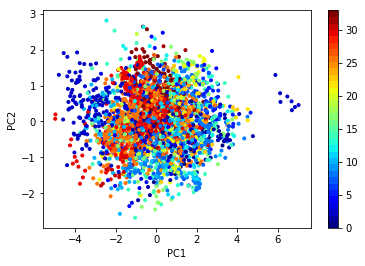

In [51]:
plt.scatter(feature5[:,0],feature5[:,1], marker=".", c=y_train_vec, cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

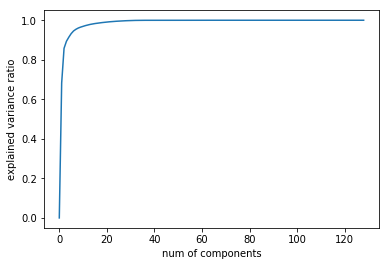

In [52]:
pca.fit(hidden5)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0, ev_ratio.cumsum()])
plt.xlabel("num of components")
plt.ylabel("explained variance ratio")
plt.plot(ev_ratio)
plt.show()

# 6層目の特徴ベクトル(MaxPooling2D)

In [53]:
feature6 = pca.fit_transform(hidden6)

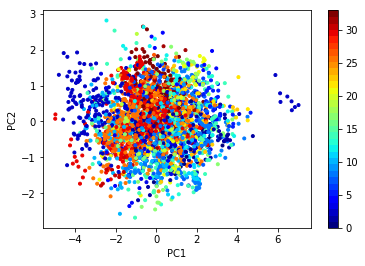

In [54]:
plt.scatter(feature6[:,0],feature6[:,1], marker=".", c=y_train_vec, cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

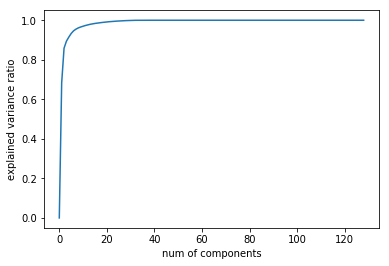

In [55]:
pca.fit(hidden6)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0, ev_ratio.cumsum()])
plt.xlabel("num of components")
plt.ylabel("explained variance ratio")
plt.plot(ev_ratio)
plt.show()

# grad-cam

In [56]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
true = []
for i in range(num_s_class):
    true.append(i)

In [57]:
pred = []

grad_last_conv = model.get_layer("conv2d_3")
model_output = model.output[:,0]
grads = K.gradients(model_output, grad_last_conv.output)[0]
pooled_grads = K.mean(grads, axis=(0,1,2))
iterate = K.function([model.input], [pooled_grads, grad_last_conv.output[0]])

for n in range(len(grad_test_img_path)):
    img_keras = image.load_img(grad_test_img_path[n], target_size=(224, 224))
    img_tensor = image.img_to_array(img_keras)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    predicts = model.predict(img_tensor)
    s_class_num = np.argmax(predicts)
    pred.append(s_class_num)
    img_tensor /= 255.
    pooled_grads_val, conv_output_val = iterate([img_tensor])
    for i in range(pooled_grads_val.shape[0]):
        conv_output_val[:, :, i] *= pooled_grads_val[i]
    heatmap = np.mean(conv_output_val, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    img = cv2.imread(grad_test_img_path[n])
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    save_dir = '../data/gradcam_img/selfCNN/'+s_classlist[n]
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)	# Make a directory
    #保存先ディレクトリ名はその画像のクラス，画像の予測値を画像の名前に書き込む
    cv2.imwrite(save_dir+'/heatmap_pred_'+s_classlist[s_class_num]+'.jpg', superimposed_img)
    print('Saved: ', save_dir+'/heatmap_pred_'+s_classlist[s_class_num]+'.jpg')

The prediction is 4gokan_inside, The truth is 4gokan_inside. The answer is False


/home/tamaru/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Saved:  ../data/gradcam_img/selfCNN/4gokan_inside/heatmap_pred_4gokan_inside.jpg
The prediction is lab_table, The truth is 4gokan_outside. The answer is True
Saved:  ../data/gradcam_img/selfCNN/4gokan_outside/heatmap_pred_lab_table.jpg
The prediction is 5gokan-mediacenter, The truth is 5gokan-denkisogokan. The answer is True
Saved:  ../data/gradcam_img/selfCNN/5gokan-denkisogokan/heatmap_pred_5gokan-mediacenter.jpg
The prediction is 4gokan_outside, The truth is 5gokan-mediacenter. The answer is True
Saved:  ../data/gradcam_img/selfCNN/5gokan-mediacenter/heatmap_pred_4gokan_outside.jpg
The prediction is 5gokan_1F, The truth is 5gokan_1F. The answer is True
Saved:  ../data/gradcam_img/selfCNN/5gokan_1F/heatmap_pred_5gokan_1F.jpg
The prediction is 5gokan_2F, The truth is 5gokan_2F. The answer is True
Saved:  ../data/gradcam_img/selfCNN/5gokan_2F/heatmap_pred_5gokan_2F.jpg
The prediction is 5gokan_3F, The truth is 5gokan_3F. The answer is True
Saved:  ../data/gradcam_img/selfCNN/5gokan_3F/

In [ ]:
cmx = confusion_matrix(true, pred)
plt.figure(figsize=(12,12))
sns.heatmap(cmx, annot=True)
plt.ylabel("truth")
plt.xlabel("prediction")
plt.show()

In [ ]:
cor_table = pd.read_csv('cor_table.csv')
print(cor_table)

# VGG16(weight="ImageNet", include_top=False)

In [58]:
from tensorflow.keras.applications.vgg16 import VGG16

In [59]:
vgg_model = VGG16(weights='imagenet', include_top=False)

In [60]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

top(全結合層など)はデフォルトだとImageNetの全クラス数1000での出力になるので，
自作のアーキテクチャを使用する
top以外のモデルの重みは(ImageNetで)固定しない→学習をする

Fine-tuning(Flozen(Not training vgg layers))
training all layers -> acc: 0.1...

In [61]:
inputs = Input(shape=(224,224,3))
x1 = vgg_model(inputs)
x2 = Flatten()(x1)
x3 = Dense(256, activation='relu')(x2)
prediction = Dense(num_s_class, activation='softmax')(x3)
full_model = Model(inputs=inputs, outputs=prediction)
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto')
for layer in vgg_model.layers[:15]:
    layer.trainable = False
full_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [62]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 34)                8738      
Total params: 21,146,210
Trainable params: 13,510,946
Non-trainable params: 7,635,264
_________________________________________________________________


In [63]:
skf = StratifiedKFold(n_splits=5, random_state=42)
cvscores = []
#Stratified KFoldはlabel encoding化した整数ベクトルでないともちいることができない
for train_index, test_index in skf.split(x, y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #One-hot化　CNNに入出力できるように整形
    y_train = np_utils.to_categorical(y_train, num_s_class)
    y_test = np_utils.to_categorical(y_test, num_s_class)
    full_model.fit(x_train, y_train, verbose=1, batch_size=batch_size, epochs=n_epochs,
              callbacks=[early_stopping], validation_split=0.2)
    scores = full_model.evaluate(x_test, y_test)
    print("%s: %.2f%%" % (full_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

Train on 2639 samples, validate on 660 samples
Epoch 1/50
2639/2639 [==============================] - 13s 5ms/sample - loss: 3.0074 - acc: 0.2027 - val_loss: 2.4426 - val_acc: 0.3212
Epoch 2/50
2639/2639 [==============================] - 11s 4ms/sample - loss: 1.9303 - acc: 0.4608 - val_loss: 1.3332 - val_acc: 0.6258
Epoch 3/50
2639/2639 [==============================] - 11s 4ms/sample - loss: 0.9424 - acc: 0.7370 - val_loss: 0.6304 - val_acc: 0.8303
Epoch 4/50
2639/2639 [==============================] - 11s 4ms/sample - loss: 0.4013 - acc: 0.8886 - val_loss: 0.3860 - val_acc: 0.9091
Epoch 5/50
2639/2639 [==============================] - 11s 4ms/sample - loss: 0.2178 - acc: 0.9341 - val_loss: 0.2555 - val_acc: 0.9530
Epoch 6/50
2639/2639 [==============================] - 11s 4ms/sample - loss: 0.1221 - acc: 0.9674 - val_loss: 0.2400 - val_acc: 0.9561
Epoch 7/50
2639/2639 [==============================] - 11s 4ms/sample - loss: 0.0577 - acc: 0.9837 - val_loss: 0.1983 - val_acc: 0

In [64]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

97.31% (+/- 1.66%)


In [65]:
y_pred = full_model.predict(x_valid)

In [66]:
y_pred = np.array(y_pred)
y_true = np.array(y_valid)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_true, axis=1)

# Confusion Matrix

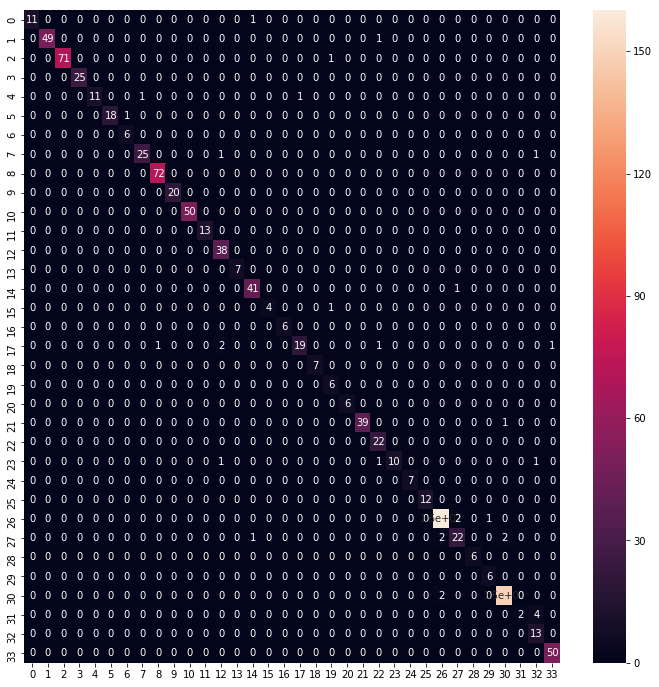

accuracy: 0.9681467181467182


In [67]:
cmx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cmx, annot=True)
plt.show()
print('accuracy: {}'.format(accuracy_score
(y_true, y_pred)))

In [68]:
cor_table = pd.read_csv('cor_table.csv')
print(cor_table)

                      s_class
0           ['4gokan_inside']
1          ['4gokan_outside']
2     ['5gokan-denkisogokan']
3      ['5gokan-mediacenter']
4               ['5gokan_1F']
5               ['5gokan_2F']
6               ['5gokan_3F']
7         ['5gokan_ent_east']
8           ['5gokan_lounge']
9         ['5gokan_out_east']
10         ['5gokan_parking']
11         ['5gokan_smoking']
12      ['5gokan_stairs_cnt']
13     ['5gokan_stairs_west']
14              ['8gokan_1F']
15       ['8gokan_ent_north']
16       ['8gokan_ent_south']
17        ['denkisogokan_2F']
18        ['denkisogokan_3F']
19        ['denkisogokan_4F']
20  ['denkisogokan_elevator']
21    ['denkisogokan_lounge']
22    ['denkisogokan_stairs']
23             ['lab-lounge']
24             ['lab_bs_cnt']
25             ['lab_corner']
26               ['lab_desk']
27         ['lab_desk_table']
28                ['lab_ent']
29            ['lab_printer']
30              ['lab_table']
31             ['lab_wb_cnt']
32        

# 中間層特徴量の可視化

In [69]:
x1 = vgg_model.get_layer('block1_pool').output
output1 = GlobalMaxPooling2D()(x1)
block_model1 = Model(inputs=vgg_model.input, outputs=output1)

In [70]:
x2 = vgg_model.get_layer('block2_pool').output
output2 = GlobalMaxPooling2D()(x2)
block_model2 = Model(inputs=vgg_model.input, outputs=output2)

In [71]:
x3 = vgg_model.get_layer('block3_pool').output
output3 = GlobalMaxPooling2D()(x3)
block_model3 = Model(inputs=vgg_model.input, outputs=output3)

In [72]:
x4 = vgg_model.get_layer('block4_pool').output
output4 = GlobalMaxPooling2D()(x4)
block_model4 = Model(inputs=vgg_model.input, outputs=output4)

In [73]:
x5 = vgg_model.get_layer('block5_pool').output
output5 = GlobalMaxPooling2D()(x5)
block_model5 = Model(inputs=vgg_model.input, outputs=output5)

In [74]:
block1 = block_model1.predict(x_train)
block2 = block_model2.predict(x_train)
block3 = block_model3.predict(x_train)
block4 = block_model4.predict(x_train)
block5 = block_model5.predict(x_train)

In [75]:
print(block1.shape)
print(block2.shape)
print(block3.shape)
print(block4.shape)
print(block5.shape)

(3325, 64)
(3325, 128)
(3325, 256)
(3325, 512)
(3325, 512)


# block1の特徴ベクトル

In [76]:
feature1 = pca.fit_transform(block1)
#　主成分分析の例(1層目)
df_feature1 = pd.DataFrame(feature1)
print(df_feature1)

             0          1         2         3         4         5         6   \
0      9.989483   0.112819 -2.562982  0.053803 -2.000396  0.185635 -0.803939   
1     -1.215173   0.312903 -0.316370 -0.484112 -0.652069 -1.828442 -2.133394   
2     -5.855301  -0.833705 -0.204427  2.055882 -0.324089 -2.012043  0.222697   
3     -1.597813  -6.195744  0.650236  0.305924  0.289722 -2.024085 -1.691468   
4     -0.454275   1.164705  0.978385  0.977007  2.010352  1.339700 -0.486876   
5      1.632685  -6.510426  2.540066 -1.888804 -2.308054  0.681293  0.084003   
6     -4.349668  -5.654377  1.383897  2.221798  0.992811 -2.030302  4.474292   
7     -8.303169   2.668471 -1.932608  3.017777  2.346898  2.842966  2.359220   
8      1.178779  -3.487463  0.114225  1.606794  0.836999  2.323152  0.053671   
9      6.988915  -8.175565  9.622272  1.285717 -0.078595  0.276317  3.908332   
10    -6.322980  -0.538476 -0.619360 -2.118447  2.432296 -2.528181 -2.078445   
11    -5.471068   2.445910  1.083864  3.

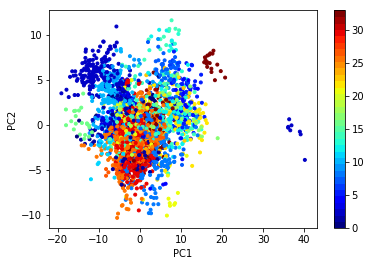

In [77]:
plt.scatter(feature1[:,0],feature1[:,1], marker=".", c=y_train_vec, cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

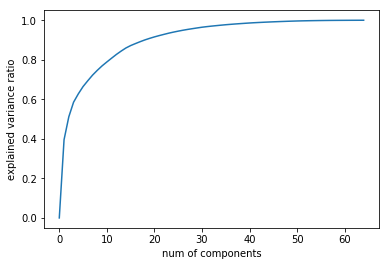

In [78]:
pca.fit(block1)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0, ev_ratio.cumsum()])
plt.xlabel("num of components")
plt.ylabel("explained variance ratio")
plt.plot(ev_ratio)
plt.show()

# block2の特徴ベクトル 

In [79]:
feature2 = pca.fit_transform(block2)

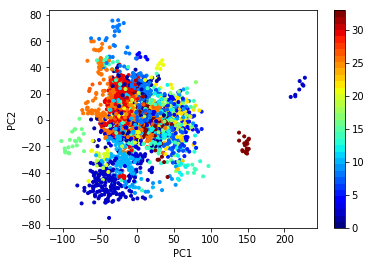

In [80]:
plt.scatter(feature2[:,0],feature2[:,1], marker=".", c=y_train_vec, cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

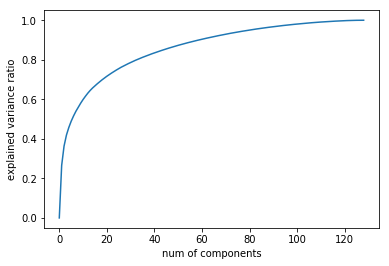

In [81]:
pca.fit(block2)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0, ev_ratio.cumsum()])
plt.xlabel("num of components")
plt.ylabel("explained variance ratio")
plt.plot(ev_ratio)
plt.show()

# block3の特徴ベクトル 

In [82]:
feature3 = pca.fit_transform(block3)

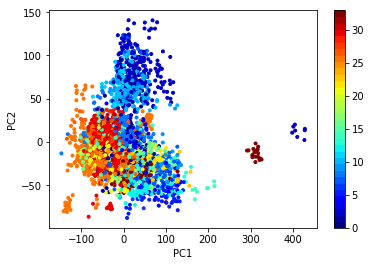

In [83]:
plt.scatter(feature3[:,0],feature3[:,1], marker=".", c=y_train_vec, cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

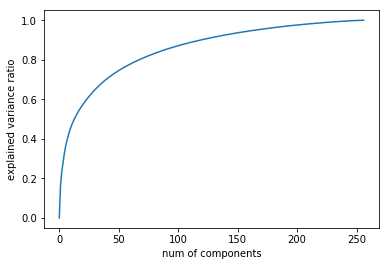

In [84]:
pca.fit(block3)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0, ev_ratio.cumsum()])
plt.xlabel("num of components")
plt.ylabel("explained variance ratio")
plt.plot(ev_ratio)
plt.show()

# block4の特徴ベクトル

In [85]:
feature4 = pca.fit_transform(block4)

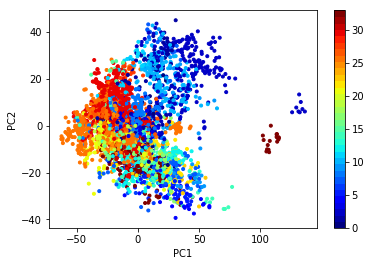

In [86]:
plt.scatter(feature4[:,0],feature4[:,1], marker=".", c=y_train_vec, cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

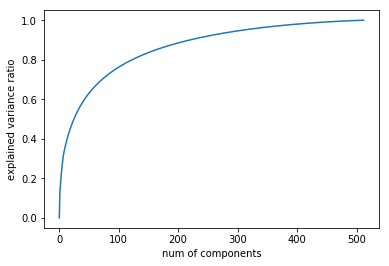

In [87]:
pca.fit(block4)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0, ev_ratio.cumsum()])
plt.xlabel("num of components")
plt.ylabel("explained variance ratio")
plt.plot(ev_ratio)
plt.show()

# block5の特徴ベクトル 

In [88]:
feature5 = pca.fit_transform(block5)

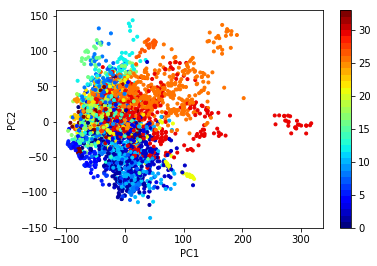

In [89]:
plt.scatter(feature5[:,0],feature5[:,1],marker=".", c=y_train_vec, cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

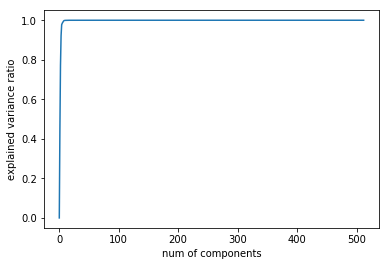

In [90]:
pca.fit(block5)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0, ev_ratio.cumsum()])
plt.xlabel("num of components")
plt.ylabel("explained variance ratio")
plt.plot(ev_ratio)
plt.show()

In [91]:
from mpl_toolkits.mplot3d import Axes3D

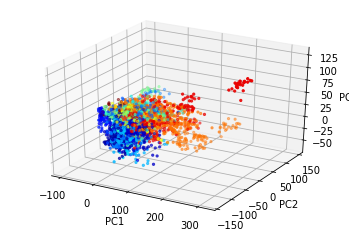

In [92]:
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(feature5[:,0],feature5[:,1], feature5[:,3], marker=".", c=y_train_vec, cmap=cmap)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

# grad-cam

# Inception v3 (Pretrained ImageNet)

In [93]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [94]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [95]:
inputs = Input(shape=(224,224,3))
x1 = base_model(inputs)
x2 = Flatten()(x1)
x3 = Dense(256, activation='relu')(x2)
prediction = Dense(num_s_class, activation='softmax')(x3)
full_model = Model(inputs=inputs, outputs=prediction)
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto')
for layer in model.layers[:249]:
    layer.trainable = False
    if layer.name.startswith('batch_normalization'):
        layer.trainable = True
full_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

top(全結合層など)はデフォルトだとImageNetの全クラス数1000での出力になるので，
自作のアーキテクチャを使用する
top以外のモデルの重みは(ImageNetで)固定しない→学習をする

Fine-tuning(Flozen(Not training InceptionV3 layers))

In [96]:
skf = StratifiedKFold(n_splits=5, random_state=42)
cvscores = []
#Stratified KFoldはlabel encoding化した整数ベクトルでないともちいることができない
x = np.array(x)
y = np.array(y)
for train_index, test_index in skf.split(x, y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #One-hot化　CNNに入出力できるように整形
    y_train = np_utils.to_categorical(y_train, num_s_class)
    y_test = np_utils.to_categorical(y_test, num_s_class)
    full_model.fit(x_train, y_train, verbose=1, batch_size=batch_size, epochs=n_epochs,
              callbacks=[early_stopping], validation_split=0.2)
    scores = full_model.evaluate(x_test, y_test)
    print("%s: %.2f%%" % (full_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

Train on 2639 samples, validate on 660 samples
Epoch 1/50
2639/2639 [==============================] - 23s 9ms/sample - loss: 5.1064 - acc: 0.2637 - val_loss: 14.0667 - val_acc: 0.1273
Epoch 2/50
2639/2639 [==============================] - 16s 6ms/sample - loss: 2.8529 - acc: 0.3494 - val_loss: 3.9793 - val_acc: 0.3197
Epoch 3/50
2639/2639 [==============================] - 16s 6ms/sample - loss: 2.6989 - acc: 0.3945 - val_loss: 14.0127 - val_acc: 0.1182
Epoch 00003: early stopping
841/841 [==============================] - 2s 2ms/sample - loss: 13.7272 - acc: 0.1367
acc: 13.67%
Train on 2645 samples, validate on 662 samples
Epoch 1/50
2645/2645 [==============================] - 16s 6ms/sample - loss: 2.2807 - acc: 0.4155 - val_loss: 14.0486 - val_acc: 0.1284
Epoch 2/50
2645/2645 [==============================] - 16s 6ms/sample - loss: 2.3105 - acc: 0.4692 - val_loss: 2.2083 - val_acc: 0.4411
Epoch 3/50
2645/2645 [==============================] - 16s 6ms/sample - loss: 2.0079 - acc

In [97]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

28.70% (+/- 25.94%)


In [98]:
y_pred = full_model.predict(x_valid)

In [99]:
y_pred = np.array(y_pred)
y_true = np.array(y_valid)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_true, axis=1)

# Confusion Matrix

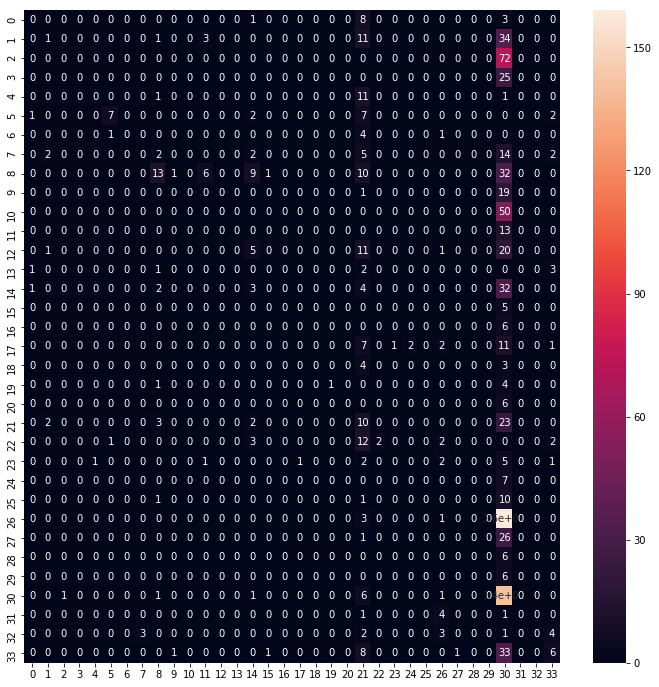

accuracy: 0.17857142857142858


In [100]:
cmx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cmx, annot=True)
plt.show()
print('accuracy: {}'.format(accuracy_score
(y_true, y_pred)))

In [101]:
cor_table = pd.read_csv('cor_table.csv')
print(cor_table)

                      s_class
0           ['4gokan_inside']
1          ['4gokan_outside']
2     ['5gokan-denkisogokan']
3      ['5gokan-mediacenter']
4               ['5gokan_1F']
5               ['5gokan_2F']
6               ['5gokan_3F']
7         ['5gokan_ent_east']
8           ['5gokan_lounge']
9         ['5gokan_out_east']
10         ['5gokan_parking']
11         ['5gokan_smoking']
12      ['5gokan_stairs_cnt']
13     ['5gokan_stairs_west']
14              ['8gokan_1F']
15       ['8gokan_ent_north']
16       ['8gokan_ent_south']
17        ['denkisogokan_2F']
18        ['denkisogokan_3F']
19        ['denkisogokan_4F']
20  ['denkisogokan_elevator']
21    ['denkisogokan_lounge']
22    ['denkisogokan_stairs']
23             ['lab-lounge']
24             ['lab_bs_cnt']
25             ['lab_corner']
26               ['lab_desk']
27         ['lab_desk_table']
28                ['lab_ent']
29            ['lab_printer']
30              ['lab_table']
31             ['lab_wb_cnt']
32        

#  最終層の特徴ベクトル 

In [102]:
x_last = base_model.get_layer('mixed10').output
output_last = GlobalMaxPooling2D()(x_last)
model_last = Model(inputs=base_model.input, outputs=output_last)

In [103]:
last_feature = model_last.predict(x_train)

In [104]:
print(last_feature.shape)

(3325, 2048)


In [105]:
last_pca = pca.fit_transform(last_feature)

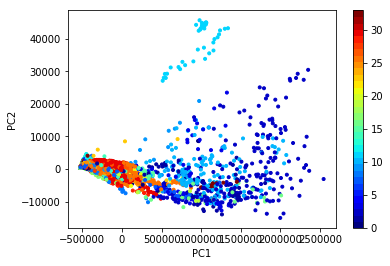

In [106]:
plt.scatter(last_pca[:,0],last_pca[:,1], marker=".", c=y_train_vec, cmap=cmap)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

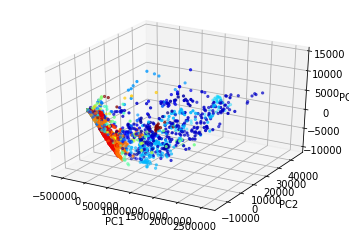

In [107]:
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(last_pca[:,0],last_pca[:,1], last_pca[:,3], marker=".", c=y_train_vec, cmap=cmap)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

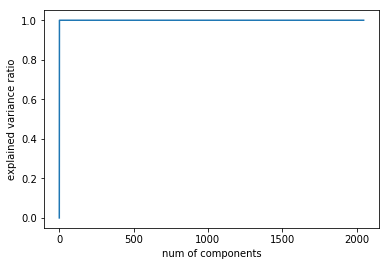

In [108]:
pca.fit(last_feature)
ev_ratio = pca.explained_variance_ratio_
ev_ratio = np.hstack([0, ev_ratio.cumsum()])
plt.xlabel("num of components")
plt.ylabel("explained variance ratio")
plt.plot(ev_ratio)
plt.show()

# grad-cam

# 非線形成分を考慮した次元削減
PCAは線形成分に注目した次元削減方法なので，非線形性を考慮した手法を試す

# 中間層の特徴量エンジニアリング

# Random Forest

In [109]:
from sklearn.ensemble import RandomForestClassifier

元画像(x_train)についてRandom Forestを行う

In [110]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)

In [111]:
#画像データそのままだとRandomForestできないのでGlobalMaxPooling2Dだけかける
x_train_pool = GlobalMaxPooling2D()(x_train)

AttributeError: 'tuple' object has no attribute 'ndims'

In [ ]:
rnd_clf.fit(x_train_pool, y_train_vec)

In [ ]:
y_pred_rf = rnd_clf.predict(x_test)

In [ ]:
y_pred_rf = np.array(y_pred_rf)
y_true = np.array(y_test)
y_pred_rf = np.argmax(y_pred_rf, axis=1)
y_true = np.argmax(y_test, axis=1)

In [ ]:
print(y_pred_rf.shape)
print(y_true.shape)

In [ ]:
cmx = confusion_matrix(y_true, y_pred_rf)
plt.figure(figsize=(12,12))
sns.heatmap(cmx, annot=True)
plt.show()
print('accuracy: {}'.format(accuracy_score
(y_true, y_pred_rf)))

In [ ]:
feature_importance = rnd_clf.feature_importances_
print(feature_importance)
print("shape:", len(feature_importance))

InceptionV3の最終層の特徴量についてRandom Forestを行う

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(last_feature, y_train_vec)

In [ ]:
last_feature_importance = rnd_clf.feature_importances_
print(last_feature_importance)
print("shape:", len(last_feature_importance))

In [ ]:
plt.imshow(last_feature_importance.reshape(32, 64), cmap="Reds")
plt.colorbar()
plt.show()

# BoVW→k-means→PCA

# ResNet50 (keras NotPretrained ImageNet)<br>
include_top: ネットワークの出力層側にある全結合層を含むかどうか．<br>
weights: None (ランダム初期化) か 'imagenet' (ImageNetで学習した重み) の一方．<br>
input_tensor: モデルの入力画像として利用するためのオプションのKerasテンソル (つまり，layers.Input()の出力)<br>
input_shape: オプショナルなshapeのタプル，include_topがFalseの場合のみ指定可能 (そうでないときは入力のshapeは(224, 224, 3) ('channels_last'データフォーマットのとき) か (3, 224, 224) ('channels_first'データフォーマットのとき) )．正確に3つの入力チャンネルをもつ必要があり，width と height は197以上にする必要があります．例えば(200, 200, 3)は有効値．<br>
pooling: 特徴量抽出のためのオプショナルなpooling mode，include_topがFalseの場合のみ指定可能．<br>
    None：モデルの出力が，最後のconvolutional layerの4階テンソルであることを意味しています．<br>
    'avg'：最後のconvolutional layerの出力にglobal average poolingが適用されることで，モデルの出力が2階テンソルになることを意味しています．<br>
    'max'：global max poolingが適用されることを意味します．<br>
classes: 画像のクラス分類のためのオプショナルなクラス数，include_topがTrueかつweightsが指定されていない場合のみ指定可能<br>

# GBDT